In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from davitpy import utils
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,6,8)
timeStart = datetime.datetime(2011,6,8,4,0)
selTime = datetime.datetime(2011,6,8,4,34) 
timeEnd = datetime.datetime(2011,6,8,7,0)
sapsRadList = [ "wal", "bks","fhe", "fhw", "cve","cvw" ]
sapsMlatRange = [ 56., 61. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam
azimRngCutoff= 35.
nAzimsCutoff = 5
sapsAzimCutoff = 30.
cutOffLshellMltRange = 0.5

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110608,300,1,0,-5.7955,24.2035,39.2449,-145.0924,12.5656,44.3930,143.6157,40,hok,2011-06-08 03:00:00,-11.4344
1,20110608,300,1,1,-2.5622,26.8421,39.7386,-144.9443,12.5755,44.9025,143.7975,40,hok,2011-06-08 03:00:00,-11.4245
2,20110608,300,1,2,-0.7420,26.4890,40.1807,-144.8334,12.5829,45.3574,143.9379,40,hok,2011-06-08 03:00:00,-11.4171
3,20110608,300,1,3,0.4915,3.9162,40.6033,-144.7371,12.5893,45.7913,144.0629,40,hok,2011-06-08 03:00:00,-11.4107
4,20110608,300,1,4,1.3994,3.9162,41.0157,-144.6486,12.5952,46.2139,144.1805,40,hok,2011-06-08 03:00:00,-11.4048


In [4]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]
# 5) Limit to selected timerange
sapsDF = sapsDF[ (sapsDF["date"] >= timeStart) &\
               (sapsDF["date"] <= timeEnd) ].reset_index(drop=True)

In [5]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

[ 439.96321476   14.65019203]


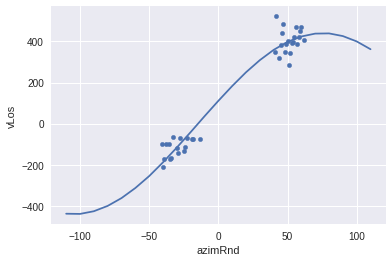

In [6]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# store the results in an array
velSaps = []
azimSaps = []
velStd = []
azimStd = []
mltSaps = []
sapsDates = []
# Get min,median and max of saps MLAT and MLT
minSapsLat = []
medSapsLat = []
maxSapsLat = []
minSapsMLT = []
medSapsMLT = []
maxSapsMLT = []
# round off normMLT for L-shell fitting
sapsDF["normMLTRnd"] = sapsDF["normMLT"].round()
sapsDF["azimRnd"] = sapsDF["azimCalcMag"].round()
# We'll try to get L-shell fitted vectors at different
# (rounded) MLTs for each given time!
uniqDatesList = sorted(sapsDF["date"].unique())
for cDate in uniqDatesList:
    currLshellDF = sapsDF[ sapsDF["date"] == cDate ]
    # get all MLTs at this time and L-shell fit the data
    mltAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
                    ].groupby("normMLTRnd").aggregate(\
                    lambda x: set(list(x))).reset_index()
    mltAzimDF.columns = [ "normMLTRnd", "azimList" ]
    mltDelAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
                    ].groupby("normMLTRnd").aggregate(\
                    lambda x: max(x) - min(x)).reset_index()
    mltDelAzimDF.columns = [ "normMLTRnd", "delAzim" ]
    mltAzimDF = pandas.merge( mltAzimDF, mltDelAzimDF )
#     if cDate == numpy.datetime64(selTime):
    # discard all MLTs where azim range is below
    # the cutoff Value
    mltAzimDF = mltAzimDF[ mltAzimDF["delAzim"] >= azimRngCutoff ]
    goodAzimMltList = mltAzimDF["normMLTRnd"].unique()
    for currMlt in goodAzimMltList:
        fitsDF = currLshellDF[ \
                         numpy.abs(currLshellDF["normMLTRnd"] - currMlt) <= cutOffLshellMltRange\
                        ].reset_index(drop=True)
#             print goodAzimMltList
        fitsDF = fitsDF.groupby("azimRnd").max().reset_index()
        # get min,median and max of MLAT, MLT of SAPS scatter
        # MLAT
        minSapsLat.append( fitsDF["MLAT"].min() )
        medSapsLat.append( fitsDF["MLAT"].median() )
        maxSapsLat.append( fitsDF["MLAT"].max() )
        # MLT
        minSapsMLT.append( fitsDF["normMLT"].min() )
        medSapsMLT.append( fitsDF["normMLT"].median() )
        maxSapsMLT.append( fitsDF["normMLT"].max() )
        # Fit the data
        popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                            fitsDF["azimRnd"].T,\
                            fitsDF['vLos'].T,
                           p0=initGuess)
        velSaps.append( popt[0] )
        azimSaps.append( popt[1] )
        velStd.append( pcov[0,0]**0.5 )
        azimStd.append( pcov[1,1]**0.5 )
        sapsDates.append( cDate )
        mltSaps.append( currMlt )
        if currMlt == -1:
            if cDate == numpy.datetime64(selTime):
                fitsDF.plot( x="azimRnd", y="vLos", kind="scatter", ax=ax )
                thetaArr = range(-110, 120, 10)
                vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
                print popt
                ax.plot( thetaArr, vLosArr )
        
            
                
# convert fit results to a dataframe
fitResultsDF = pandas.DataFrame(
     {'date': sapsDates,
     'velSAPS': velSaps,
      'mltSAPS': mltSaps,
     'azimSAPS': azimSaps,
     'velSTD': velStd,
     'azimSTD': azimStd,
     'minLat': minSapsLat,
     'medLat': medSapsLat,
     'maxLat': maxSapsLat,
     'minMLT': minSapsMLT,
     'medMLT': medSapsMLT,
     'maxMLT': maxSapsMLT,
    })

In [7]:
print fitResultsDF
# write results to dataframe
feather.write_dataframe(fitResultsDF, '../data/lshell-fits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

      azimSAPS    azimSTD                date   maxLat  maxMLT    medLat  \
0    91.358937  11.594226 2011-06-08 04:08:00  60.8178  0.3144  59.80970   
1    76.180049  15.134774 2011-06-08 04:10:00  60.6539  0.3130  59.55330   
2    77.415258  16.457594 2011-06-08 04:12:00  60.5115  0.3458  59.42270   
3    56.153828  20.690777 2011-06-08 04:14:00  60.6539  0.4822  59.38305   
4    71.456240  19.837697 2011-06-08 04:16:00  60.6539  0.4802  59.32195   
5    69.528765  25.830271 2011-06-08 04:18:00  60.6539  0.4786  59.34340   
6    12.453285   2.057439 2011-06-08 04:20:00  59.2093 -1.0882  58.85430   
7    65.615859  28.545414 2011-06-08 04:20:00  60.6539  0.4770  59.34340   
8    15.176396   2.985842 2011-06-08 04:22:00  59.2093 -1.0554  59.14290   
9    12.262756   1.708875 2011-06-08 04:24:00  59.9661 -0.9230  58.90035   
10  -10.734815   7.703039 2011-06-08 04:26:00  60.9323 -2.5987  59.61630   
11    9.076082   1.540507 2011-06-08 04:26:00  59.9661 -0.8899  58.98960   
12    8.9430

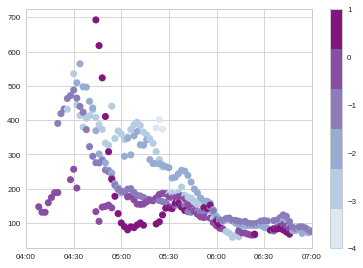

In [8]:
# filter the data
# fitResultsDF = fitResultsDF[ numpy.abs(fitResultsDF["azimSAPS"]) <= sapsAzimCutoff ]
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
# fig
seaMap = ListedColormap(sns.color_palette("BuPu"))
fig = plt.figure()
ax = fig.add_subplot(111)
smap = ax.scatter(fitResultsDF['date'].values,fitResultsDF['velSAPS'].values,s=50,c=fitResultsDF['mltSAPS'].values,
                  edgecolors='none', marker='o', cmap=seaMap) 
cb = fig.colorbar(smap, orientation='vertical')
ax.set_xlim( [ timeStart, timeEnd ] )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

In [9]:
# # fig1 = plt.figure()
# # ax = fig1.add_subplot(111)
# # store the results in an array
# velSaps = []
# azimSaps = []
# velStd = []
# azimStd = []
# mltSaps = []
# sapsDates = []
# # Get min,median and max of saps MLAT and MLT
# minSapsLat = []
# medSapsLat = []
# maxSapsLat = []
# minSapsMLT = []
# medSapsMLT = []
# maxSapsMLT = []
# # round off normMLT for L-shell fitting
# sapsDF["normMLTRnd"] = sapsDF["normMLT"].round()
# sapsDF["azimRnd"] = sapsDF["azimCalcMag"].round()
# # We'll try to get L-shell fitted vectors at different
# # (rounded) MLTs for each given time!
# uniqDatesList = sorted(sapsDF["date"].unique())
# for cDate in uniqDatesList:
#     currLshellDF = sapsDF[ sapsDF["date"] == cDate ]
#     # get all MLTs at this time and L-shell fit the data
#     mltAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
#                     ].groupby("normMLTRnd").aggregate(\
#                     lambda x: set(list(x))).reset_index()
#     mltAzimDF.columns = [ "normMLTRnd", "azimList" ]
#     mltDelAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
#                     ].groupby("normMLTRnd").aggregate(\
#                     lambda x: max(x) - min(x)).reset_index()
#     mltDelAzimDF.columns = [ "normMLTRnd", "delAzim" ]
#     mltAzimDF = pandas.merge( mltAzimDF, mltDelAzimDF )
# #     if cDate == numpy.datetime64(selTime):
#     # discard all MLTs where azim range is below
#     # the cutoff Value
#     mltAzimDF = mltAzimDF[ mltAzimDF["delAzim"] >= azimRngCutoff ]
#     goodAzimMltList = mltAzimDF["normMLTRnd"].unique()
#     for currMlt in goodAzimMltList:
#         fitsDF = currLshellDF[ \
#                          currLshellDF["normMLTRnd"] == currMlt\
#                         ].reset_index(drop=True)
# #             print goodAzimMltList
# #             if currMlt == -1:
#         fitsDF = fitsDF.groupby("azimRnd").median().reset_index()
# #                 fitsDF.plot( x="azimRnd", y="vLos", kind="scatter", ax=ax )
#         # get min,median and max of MLAT, MLT of SAPS scatter
#         # MLAT
#         minSapsLat.append( fitsDF["MLAT"].min() )
#         medSapsLat.append( fitsDF["MLAT"].median() )
#         maxSapsLat.append( fitsDF["MLAT"].max() )
#         # MLT
#         minSapsMLT.append( fitsDF["normMLT"].min() )
#         medSapsMLT.append( fitsDF["normMLT"].median() )
#         maxSapsMLT.append( fitsDF["normMLT"].max() )
#         # Fit the data
#         popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
#                             fitsDF["azimRnd"].T,\
#                             fitsDF['vLos'].T,
#                            p0=initGuess)
#         velSaps.append( popt[0] )
#         azimSaps.append( popt[1] )
#         velStd.append( pcov[0,0]**0.5 )
#         azimStd.append( pcov[1,1]**0.5 )
#         sapsDates.append( cDate )
#         mltSaps.append( currMlt )
# #             thetaArr = range(-110, 120, 10)
# #             vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
# #                 ax.plot( thetaArr, vLosArr )
            
                
# # convert fit results to a dataframe
# fitResultsDF = pandas.DataFrame(
#      {'date': sapsDates,
#      'velSAPS': velSaps,
#       'mltSAPS': mltSaps,
#      'azimSAPS': azimSaps,
#      'velSTD': velStd,
#      'azimSTD': azimStd,
#      'minLat': minSapsLat,
#      'medLat': medSapsLat,
#      'maxLat': maxSapsLat,
#      'minMLT': minSapsMLT,
#      'medMLT': medSapsMLT,
#      'maxMLT': maxSapsMLT,
#     })